# Imports

In [5]:
from bs4 import BeautifulSoup
from collections import Counter
import datetime
import os
import re

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import requests
from unidecode import unidecode

# Static variables

In [8]:
OUTPUT_DIR = 'output'
ROOT_URL = 'https://digitalcommons.library.tmc.edu/utgsbs_dissertations'

# Get into it

In [116]:
# Generate a file of all possible URLs...
# Apparently this is faster than keeping the request open to process the HTML
keep_exec = True
none_worked = 0
url_ext = 0
url_worked = []

while keep_exec:
    # Try 100 times and if it fails then stop ...
    # This should be good based on the sitemap generator
    if none_worked == 100:
        keep_exec = False

    url = f'{ROOT_URL}/{url_ext}/'
    response = requests.get(url)

    if response.status_code == 200:
        print(f'FOUND: {url}')
        url_worked.append(url)
    else:
        # That URL didn't work ...
        # Try 100 more times and if it fails then stop ...
        # This should be good based on the sitemap generator
        none_worked += 1
    url_ext += 1

FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/1/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/2/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/3/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/4/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/5/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/6/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/7/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/8/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/9/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/10/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/11/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/12/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/13/
FOUND: https://digitalcommons.library.tmc.edu/utgsbs_dissertations/14/
FOUND: https://

In [118]:
def clean_name(name):
    # Account for multiple advisors
    split_types = ['&amp;', ' and ', '/']
    for split_type in split_types:
        if split_type in name:
            name = [a.strip() for a in name.split(split_type)]
    return name


def get_advisor(all_members):
    # Get the advisor from all committee members
    try:
        advisor = [m for m in all_members if m[0]=='advisor'][0][1]
        return advisor
    except IndexError:
        return None


all_results = []
for url in url_worked:
    # Get the content of the page
    url_text = requests.get(url).text
    soup = BeautifulSoup(url_text)
    # Title
    matched_text = str(soup.find('div', {'id': 'title'}))
    try:
        title = re.findall('">(.*?)</a>', matched_text)[0].title()
    except IndexError:
        # This title is not a URL
        try:
            title = re.findall('<p>(.*?)</p>', matched_text)[0].title()
        except IndexError:
            # This happens if a paper has been withdrawn
            continue
    # Date
    # YYYY, M-YYYY
    matched_text = str(soup.find('div', {'id': 'publication_date'}))
    pub_date = re.findall('<p>(.*?)</p>', matched_text)[0]
    split_date = pub_date.split('-')
    if len(split_date) == 1:
        month = None
        year = int(split_date[0])
    elif len(split_date) == 2:
        month = int(split_date[0])
        year = int(split_date[1])
    else:
        print(pub_date, url)
    # Affiliation
    matched_text = str(soup.find('div', {'id': 'affiliation'}))
    affiliation = re.findall('<p>(.*?)</p>', matched_text)[0]
    # Degree
    matched_text = str(soup.find('div', {'id': 'degree_name'}))
    degree_name = re.findall('<p>(.*?)</p>', matched_text)[0]
    # Committee
    all_members = soup.find_all('div', {'id': re.compile('advisor')})
    all_members = [
        (
            'advisor' if 'Advisor' in re.findall('<h4>.*</h4>', str(m))[0] else 'member',
            re.findall('<p>(.*)</p>', str(m))[0]
        ) 
        for m in all_members
    ]
    # Account for multiple members in one field
    all_members = [(m[0],clean_name(m[1])) for m in all_members]
    temp_members = []
    for m in all_members:
        if type(m[1]) is list:
            for mm in m[1]:
                temp_members.append((m[0],mm))
        else:
            temp_members.append(m)
    all_members = temp_members

    # Compile all the results together
    all_results.append([title, month, year, affiliation, degree_name, get_advisor(all_members), [m[1] for m in all_members if m[0]!='advisor']])
    print(f'{url}: DONE')

# Create the dataframe
df = pd.DataFrame(
    all_results,
    columns=['title','month','year','affiliation','degree','advisor','members'],
)
# Ints can't go with NaNs without this weird datatype in pandas
df = df.astype({'month':'Int64', 'year':'Int64'})
# Save to a file to prevent re-running
current_date = str(datetime.datetime.now()).replace(' ','_').replace(':','-').split('.')[0]
df.to_csv(os.path.join(OUTPUT_DIR, f'all_results___{current_date}.csv'), index=False)
# See what it looks like
df.head()

https://digitalcommons.library.tmc.edu/utgsbs_dissertations/1/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/2/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/3/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/4/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/5/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/6/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/7/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/8/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/9/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/10/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/11/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/12/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/13/: DONE
https://digitalcommons.library.tmc.edu/utgsbs_dissertations/14/: DONE
https://digitalcommons.librar

,title,month,year,affiliation,degree,advisor,members
0,Regulation Of Survivin Gene Expression In The ...,<NA>,2009,Biochemistry and Molecular Biology,Doctor of Philosophy (PhD),David Loose,[]
1,Identification Of A Conserved Cluster In The R...,12,2009,Cell and Regulatory Biology,Doctor of Philosophy (PhD),Richard B Clark,"[Carmen W Dessauer, Jeffrey A Frost, Olivier L..."
2,Targeted Inhibition Of Sp1 Transcription Facto...,5,2010,Cancer Biology,Doctor of Philosophy (PhD),Keping Xie,"[Kenneth Aldape, Zhen Fan, Juan Fueyo-Margaret..."
3,"Preeclampsia, Autoimmunity And The At1 Receptor",5,2010,Biomedical Sciences,Doctor of Philosophy (PhD),"Dr. Yang Xia, MD, PhD","[Dr. Jeffrey K. Actor, PhD, Dr. Michael R. Bla..."
4,The Physiological And Biochemical Understandin...,12,2009,Biomedical Sciences,Masters of Science (MS),Cheng Chi Lee,"[Michael Blackburn, William Dubinsky, Henry St..."


# Try to consolidate the members due to different spellings

In [9]:
# Load the data
df = pd.read_csv(os.path.join(OUTPUT_DIR, 'all_results___2023-07-10_01-26-03.csv'))

In [10]:
# Have to do this manually since `difflib` failed me

# Remove acronyms at the end of the name
# TODO: ma?, do?
acronyms = ['ii','iii','jr','md','phd','mb','bchir','scd','mrcp','fracp','mbbs','dr','advisory','professor']

# Get all the members
all_members = df['advisor'].tolist() + list(set([mm for m in df['members'].tolist() for mm in re.findall("\'(.*?)\'", m)]))
all_members = list(set([m for m in all_members if type(m) is str]))
# Remove accents
all_members = [unidecode(unidecode(m, 'utf-8')) for m in all_members]

# Get only the first and last names
all_fl_names = list(set([m.split(',')[0] for m in all_members]))
new_fl_names = []
for n in all_fl_names:
    # Remove stuff between parentheses
    n = re.sub('\(.*?\)', '', n)
    temp_split = n.split(' ')
    final_combo = []
    for nn in temp_split:
        # Remove anything with a `.`, single letter, or acronym
        if ('.' not in nn) and (len(nn) > 1) and (nn.lower() not in acronyms):
            final_combo.append(nn)
    new_fl_names.append(' '.join(final_combo))
all_fl_names = list(set([n.title() for n in new_fl_names]))
# Remove those without first and last name since they are caused by errors
all_fl_names = [n for n in all_fl_names if len(n.split(' '))>1]
all_fl_names = [(n.split(' ')[0],n.split(' ')[-1]) for n in all_fl_names]

# NOTE: Access this dictionary by searching `(first_name,last_name)`
# This will give you all the aliased versions
# NOTE: this is not perfect but appears to be ~99%, typos and errors in the HTML cause the issues
name_matches = {}
for name_combo in all_fl_names:
    name_matches[name_combo] = [n for n in all_members if ((name_combo[0].lower() in n.lower()) and (name_combo[1].lower() in n.lower()))]
name_matches

# all_matched_names = [mm for m in matches for mm in m[1]]
# Unmatched names
# print([m for m in all_members if m not in all_matched_names])

# Could use the longest version of the name and replace everything
# final_names = [sorted(m[1], key=lambda mm:len(mm))[-1] for m in matches]

{('Kandice', 'Levental'): ['Kandice Levental, PhD'],
 ('Gabriel', 'Sawakuchi'): ['Gabriel Sawakuchi',
  'Gabriel Sawakuchi, Ph.D.',
  'Gabriel O. Sawakuchi',
  'Gabriel O. Sawakuchi, Ph.D.'],
 ('Nora', 'Navone'): ['Dr. Nora M. Navone',
  'Nora M. Navone',
  'Dr. Nora Navone',
  'Nora M. Navone, M.D., Ph.D.'],
 ('Jacqueline', 'Parchem'): ['Jacqueline Parchem, MD'],
 ('Carol', 'Etzel'): ['Carol Etzel',
  'Carol Etzel, Ph.D.',
  'Carol J. Etzel, Ph.D.',
  'Carol J. Etzel, PhD'],
 ('Aranza', 'Cendejas'): ['Aranza Gonzalez Cendejas',
  'Aranza Gonzalez Cendejas, MS, CGC'],
 ('Jeffrey', 'Morris'): ['Jeffrey Morris',
  'Jeffrey S. Morris',
  'Jeffrey Morris, Ph.D.',
  'Dr. Jeffrey Morris',
  'Jeffrey S. Morris, Ph.D.'],
 ('Laszlo', 'Radvanyi'): ['Laszlo Radvanyi',
  'Laszlo G. Radvanyi, Ph.D.',
  'Laszlo Radvanyi, PhD'],
 ('Gabriela', 'Bowden'): ['Dr. Gabriela Bowden'],
 ('Cynthia', 'Ju'): ['Cynthia Ju, Ph.D.', 'Changqing Cynthia Ju, Ph.D.'],
 ('James', 'Bates'): ['James E. Bates, M.D.'],
 ('

# Visualize it

In [273]:
# NOTE: known errors
# degree: `&lt;-- Please Select One --&gt;`
# df

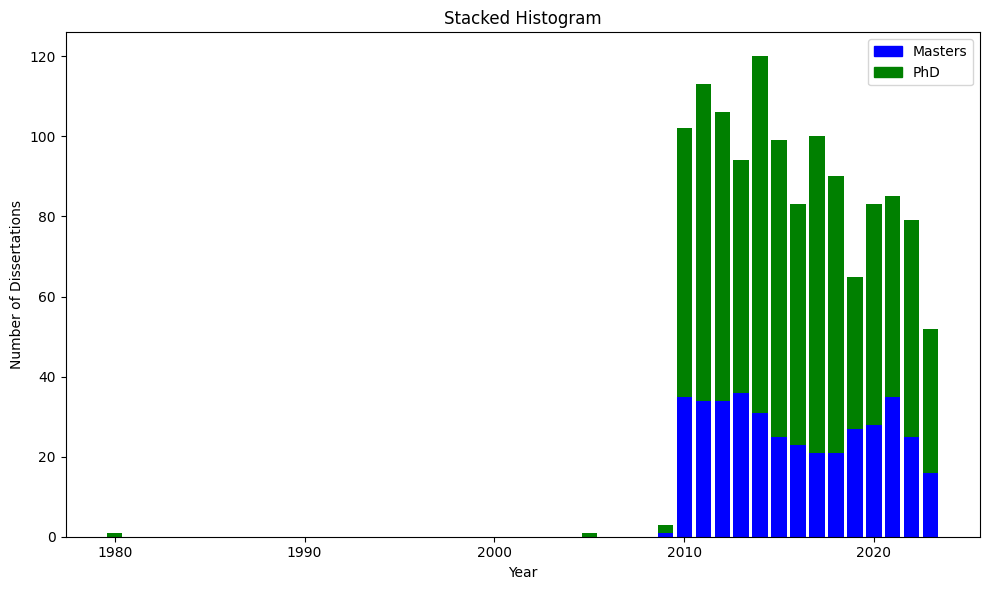

In [11]:
# Compare number of masters and phd dissertations per year
masters_df = df[df['degree'] == 'Masters of Science (MS)']['year'].tolist()
phd_df = df[df['degree'] == 'Doctor of Philosophy (PhD)']['year'].tolist()

plt.figure(figsize=(10,6))
labels = ['Masters','PhD']
colors = ['b','g']
plot_dfs = [dict(Counter(d)) for d in [masters_df, phd_df]]
for i in range(2):
    for combo in plot_dfs[i].items():
        year = combo[0]
        count = combo[1]
        if i == 0:
            bottom = 0
        else:
            try:
                bottom = plot_dfs[0][year]
            except KeyError:
                bottom = 0
        plt.bar(year, count, bottom=bottom, color=colors[i], label=labels[i])
plt.xlabel('Year')
plt.ylabel('Number of Dissertations')
plt.title('Stacked Histogram')
plt.legend(handles=[mpatches.Patch(color='b', label='Masters'), mpatches.Patch(color='g', label='PhD')])
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stacked_degree_distribution.png'))
plt.show()

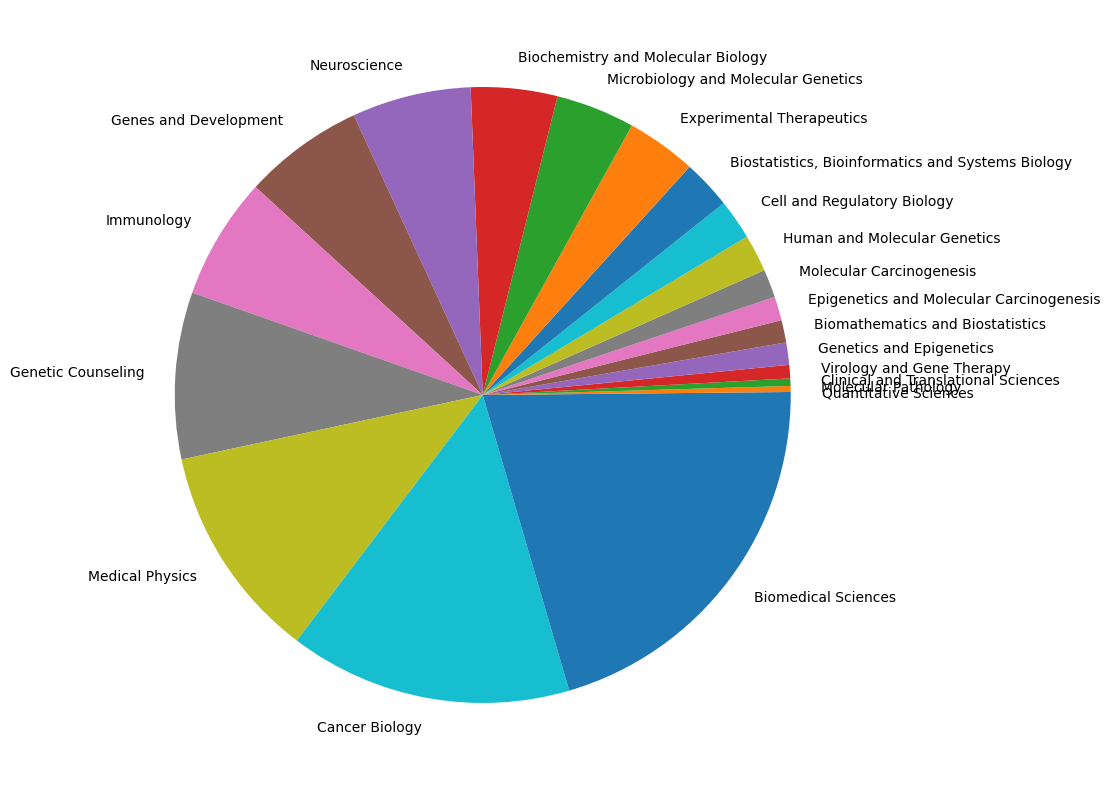

In [12]:
# Find distribution by program type
plt.figure(figsize=(12,8))
ax = plt.gca()
labels = list(set(df['affiliation'].tolist()))
sizes = [100*len(df[df['affiliation']==l].index)/len(df.index) for l in labels]
sorted_combos = sorted(list(zip(labels,sizes)), key=lambda s: s[1])
ax.pie([c[1] for c in sorted_combos], labels=[c[0] for c in sorted_combos])
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'affiliation_pie_chart.png'))
plt.show()

In [13]:
# Find all the dissertations by a certain professor
# (first_name, last_name)
prof_name = ('Michael', 'Blackburn')
all_aliases = name_matches[prof_name]

all_matches = []
for _,row in df.iterrows():
    temp_advisor = str(row['advisor'])
    if temp_advisor.startswith('['):
        temp_advisor = list(temp_advisor)
    else:
        temp_advisor = [temp_advisor]
    temp_members = str(row['members'])
    if temp_members.startswith('['):
        temp_members = re.findall("\'(.*?)\'", temp_members)
    temp_all_members = temp_advisor + temp_members
    # Find the matches
    if set(all_aliases).intersection(set(temp_all_members)):
        all_matches.append(row)

matched_df = pd.DataFrame(all_matches)
matched_df

,title,month,year,affiliation,degree,advisor,members
3,"Preeclampsia, Autoimmunity And The At1 Receptor",5.0,2010,Biomedical Sciences,Doctor of Philosophy (PhD),"Dr. Yang Xia, MD, PhD","['Dr. Jeffrey K. Actor, PhD', 'Dr. Michael R. ..."
4,The Physiological And Biochemical Understandin...,12.0,2009,Biomedical Sciences,Masters of Science (MS),Cheng Chi Lee,"['Michael Blackburn', 'William Dubinsky', 'Hen..."
12,The Role Of A2B Adenosine Receptor Signaling I...,5.0,2010,Biochemistry and Molecular Biology,Doctor of Philosophy (PhD),"Michael R. Blackburn, Ph.D.","['Scott Drouin, Ph.D.', 'Christopher M. Evans,..."
46,Osteopontin And Cadherin 11 Are Novel Mediator...,5.0,2010,Biomedical Sciences,Doctor of Philosophy (PhD),Michael R. Blackburn Ph.D.,"['Sandeep K. Agarwal M.D., Ph.D.', 'Russel Bro..."
87,Stress-Induced Targeting Of Molecular Chaperon...,12.0,2010,Microbiology and Molecular Genetics,Doctor of Philosophy (PhD),Kevin A. Morano,"['Michael C. Lorenz', 'Michael Blackburn', 'Pe..."
102,Characterizing And Treating The Neuropathology...,12.0,2010,Human and Molecular Genetics,Doctor of Philosophy (PhD),"Michael J. Gambello, M.D, Ph.D.","['Michael R. Blackburn, Ph.D.', 'Gilbert J. Co..."
141,The Role Of Il-6 In Adenosine-Mediated Pulmona...,5.0,2011,Biochemistry and Molecular Biology,Doctor of Philosophy (PhD),"Michael R. Blackburn, PhD","['Rodney E. Kellems, PhD', 'Sandeep K. Agarwal..."
146,Immune Modulation Of The Mycobacterium Tubercu...,5.0,2011,Biomedical Sciences,Doctor of Philosophy (PhD),"Jeffrey K. Actor, Ph.D.","['Michael R. Blackburn, Ph.D.', 'Robert L. Hun..."
172,A Cell Biological Determination Of Integrator ...,8.0,2011,Biochemistry and Molecular Biology,Masters of Science (MS),"Eric Wagner, Ph.D.","['Michael Blackburn, Ph.D.', 'Phillip Carpente..."
175,Uptake And Metabolism Of 5’-Amp In The Erythro...,8.0,2011,Biochemistry and Molecular Biology,Doctor of Philosophy (PhD),"Cheng Chi Lee, Ph.D.","['Diane Bick, Ph.D.', 'Michael R. Blackburn, P..."


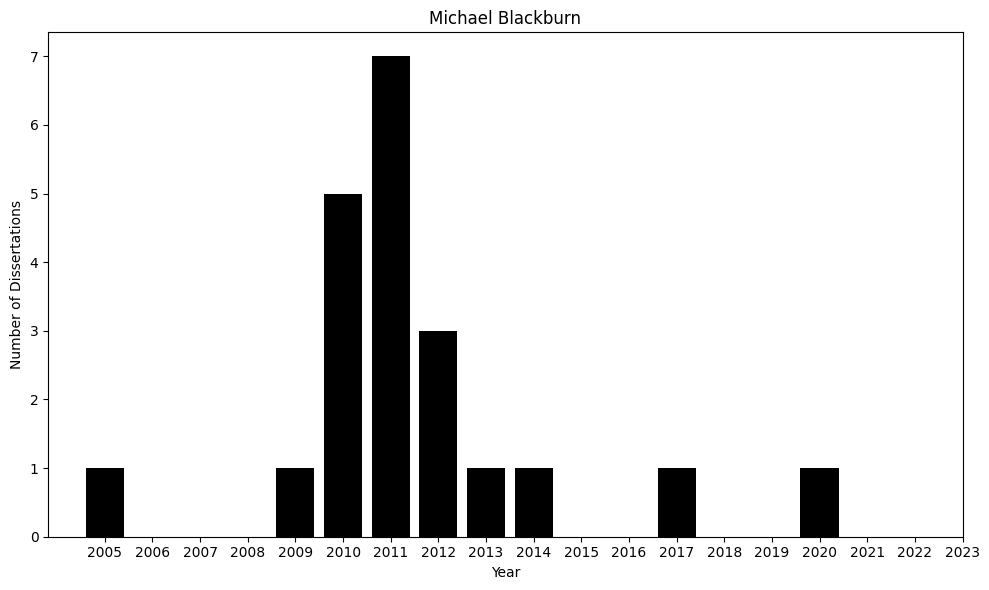

In [14]:
# Visualize the matched results
plt.figure(figsize=(10,6))
data = dict(Counter(matched_df['year'])).items()
plt.bar([d[0] for d in data], [d[1] for d in data], color='k')
ax = plt.gca()
plt.xticks(range(min([d[0] for d in data]),datetime.datetime.now().year+1))
plt.yticks(range(max([d[1] for d in data])+1))
plt.xlabel('Year')
plt.ylabel('Number of Dissertations')
plt.title(f'{prof_name[0]} {prof_name[1]}')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'dissertation_distribution___{prof_name[0]}-{prof_name[1]}.png'))
plt.show()